In [68]:
import pandas as pd
import numpy as np
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import time

import matplotlib.pyplot as plt

import pickle

In [2]:
data = pd.read_csv('cs-training-nonull.csv')

# remove unneeded
data = data.drop('id', axis = 1)

In [3]:
# global constants
N_ESTIMATORS = 1000
# numero di features compreso le due colonne indicatore aggiunte
N_FEATURES = 12

# nome della colonna con le label (da prevedere)
TARGET = 'SeriousDlqin2yrs'

# colonne con missing values
COL1_MISSING = 'MonthlyIncome'
COL2_MISSING = 'NumberOfDependents'

# nomi delle due colonne indicator (valgono 1 laddove il dato è inputato)
IND1 = 'isna_mi'
IND2 = 'isna_nod'

ind_col = [IND1, IND2]

# prese da stats sul train test, usate per inputare i missing values su COL1 e CL2
MONTHLY_INC_MEDIAN = 5400.0
N_OF_DEP_MODE = 0

In [4]:
# split in train, validation set
def split_train_test(df, ratio):
    # shuffle before split
    df = df.sample(frac = 1)
    N_REC = df.shape[0]
    N_TRAIN = int(N_REC * ratio)
    N_VALID = N_REC - N_TRAIN
    train_df = df[:N_TRAIN]
    valid_df = df[N_TRAIN:]
    
    return train_df, valid_df

In [5]:
train_df, valid_df = split_train_test(data, 0.8)

In [6]:
# metto da parte le due colonne indicatori
ind_train = train_df[ind_col].values
ind_valid = valid_df[ind_col].values

In [7]:
train_df = train_df.drop(ind_col, axis = 1)
valid_df = valid_df.drop(ind_col, axis = 1)

# estrae X: matrice features ed y, labels
y_train = train_df[TARGET].values
xtrain_df = train_df.drop(TARGET, axis = 1)
x_train = xtrain_df.values

y_valid = valid_df[TARGET].values
xvalid_df = valid_df.drop(TARGET, axis = 1)
x_valid = xvalid_df.values

In [8]:
# prepara lo scaling
scaler = StandardScaler()

# calcola i parametri di scaling solo sul train set
scaler.fit(x_train)

StandardScaler()

In [9]:
# scalo tutto tranne che le due colonne indicatore
x_train_scaled = scaler.transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

In [10]:
# riaggiungo gli indicatori
x_train_scaled = np.c_[x_train_scaled, ind_train]
x_valid_scaled = np.c_[x_valid_scaled, ind_valid]

In [11]:
# check
assert x_train_scaled.shape[1] == N_FEATURES
assert x_valid_scaled.shape[1] == N_FEATURES

### Train the XGBoost Classifier

In [12]:
param_dist = {'objective':'binary:logistic', 'n_estimators':N_ESTIMATORS,
             'learning_rate':0.007, 'max_depth': 5,
             'random_state': 0, 'min_child_weight': 10.0,
             'max_delta_step': 1.8, 'colsample_bytree': 0.4,
             'subsample': 0.8, 'eta': 0.025,
             'gamma': 0.65, 'num_boost_round' : 391}

tStart = time.time()

clf = xgb.XGBClassifier(use_label_encoder=False, **param_dist)

# valuto su train e su validation set
clf.fit(x_train_scaled, y_train,
        eval_set=[(x_train_scaled, y_train), (x_valid_scaled, y_valid)],
        eval_metric='auc', verbose=True)

tEla = time.time() - tStart

print('Elapsed time', round(tEla, 3))
print()

evals_result = clf.evals_result()

[23:23:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.79645	validation_1-auc:0.78880
[1]	validation_0-auc:0.81431	validation_1-auc:0.80712
[2]	validation_0-auc:0.84094	validation_1-auc:0.83090
[3]	validation_0-auc:0.84298	validation_1-auc:0.83155
[4]	validation_0-auc:0.84077	validation_1-auc:0.83000
[5]	validation_0-auc:0.84458	validation_1-auc:0.83304
[6]	validation_0-auc:0.85116	validation_1-auc:0.83974
[7]	validation_0-auc:0.84883	validation_1-auc:0.83722
[8]	validation_0-auc:0.85422	validation_1-auc:0.84232
[9]	validation_0-auc:0.85416	validation_1-auc:0.84295
[10]	validation_0-auc:0.85659	validation_1-auc:0.84526
[11]	validation_0-auc:0.85796	validation

In [13]:
def plot_auc(train_hist, val_hist):
    plt.figure(figsize=(14,6))
    
    plt.plot(train_hist, label='Training AUC')
    plt.plot(val_hist, label='Validation AUC')
    plt.title('AUC')
    plt.legend(loc='upper right')
    plt.ylabel('auc')
    plt.xlabel('n_estimator')
    plt.grid(True)
    plt.show();

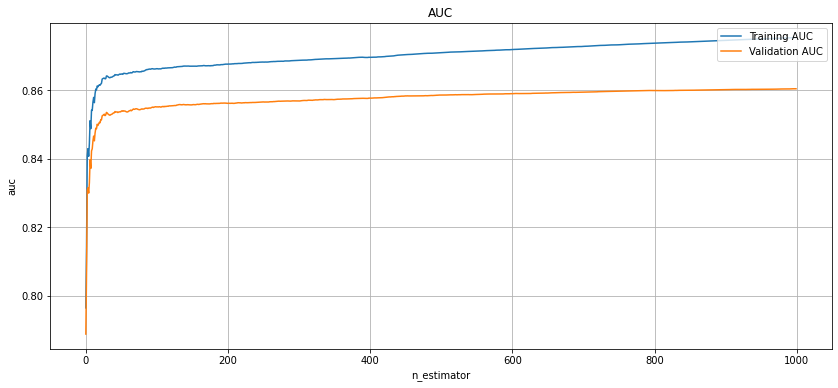

In [14]:
train_hist = evals_result['validation_0']['auc']
val_hist = evals_result['validation_1']['auc']

plot_auc(train_hist, val_hist)

In [15]:
# compute accuracy on validation set
y_pred = clf.predict(x_valid_scaled)

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_valid, predictions)

print("Accuracy on validation set: %.2f%%" % (accuracy * 100.0))

Accuracy on validation set: 93.93%


### Prediction on the TEST set (for submission to Kaggle)

In [ ]:
# predictions on test set
orig_test = pd.read_csv('cs-test.csv')

# inpute missing values, add the two indicator columns
orig_test['isna_mi'] = 0
orig_test.loc[orig_test[COL1_MISSING].isna(), 'isna_mi'] = 1
orig_test.loc[orig_test[COL1_MISSING].isna(), COL1_MISSING] = MONTHLY_INC_MEDIAN

orig_test['isna_nod'] = 0
orig_test.loc[orig_test[COL2_MISSING].isna(), 'isna_nod'] = 1
orig_test.loc[orig_test[COL2_MISSING].isna(), COL2_MISSING] = N_OF_DEP_MODE

In [ ]:
ind_test = orig_test[ind_col].values

In [ ]:
orig_test = orig_test.drop(ind_col, axis = 1)

In [ ]:
ID_COL_NAME = 'Unnamed: 0'
xorig_test = orig_test.drop(ID_COL_NAME, axis = 1)
xorig_test = xorig_test.drop(TARGET, axis = 1)

x_test = xorig_test.values

In [ ]:
# aggiungi qui lo scaling !!!
x_test_scaled = scaler.transform(x_test)
# riaggiunge le colonne indicatore
x_test_scaled = np.c_[x_test_scaled, ind_test]

assert x_test_scaled.shape[1] == N_FEATURES

In [ ]:
# do predictions on test set (no shuffle !)
y_pred = clf.predict_proba(x_test_scaled)

# y_pred contiene le probabilità
y_pred = y_pred[:, 1]

In [ ]:
# prepara il csv per la submission
result_dict = {"Id": orig_test[ID_COL_NAME].values,
              'Probability': y_pred}

FILE_SUB = 'submission25.csv'

# build a dataframe and save to csv
result_df = pd.DataFrame(result_dict)

result_df.to_csv(FILE_SUB, index=False, float_format='%.5f')

In [76]:
# save model: uso un formato semplice: pkl
pickle.dump(clf, open("credit-scoring.pkl", "wb"))

In [83]:
# salvo anche lo scaler
pickle.dump(scaler, open("scaler.pkl", "wb"))

### Online predictions

In [77]:
# reload the model
loaded_model = pickle.load(open("credit-scoring.pkl", "rb"))

In [84]:
# reload the scaler
loaded_scaler = pickle.load(open("scaler.pkl", "rb"))

In [87]:
# check
type(loaded_scaler)

sklearn.preprocessing._data.StandardScaler

In [88]:
# prepare for online predictions
# input are given as a numpy array, with no missing fields, but we need to add the two indicator columns
x_input = np.array([[1,2,3,4,5,6,7,8,9,10],
                   [1,2,3,4,5,6,7,8,9,10],
                   [1,2,3,4,5,6,7,8,9,10]])

In [89]:
# controlli
assert x_input.shape[1] == 10
# check there are no null
assert np.sum(np.isnan(x_input)) == 0

In [90]:
# normalize
x_input_scaled = loaded_scaler.transform(x_input)
# add two columns with 0
x_add = np.zeros((x_input.shape[0], 2))
x_input_scaled = np.c_[x_input_scaled, x_add]

In [96]:
y_pred = loaded_model.predict(x_input_scaled)

In [97]:
y_pred

array([1, 1, 1])